In [24]:
# Libraries

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time


In [25]:
# Data
new_data = pd.read_csv(r"abalone.csv")
new_data = np.array(new_data)

X = new_data[:, 1:]
y = new_data[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train_as_list, y_train_as_list, X_test_as_list, y_test_as_list = X_train.tolist(), y_train.tolist(), X_test.tolist(), y_test.tolist()

In [26]:
# Task 1, itteration

class KNN_itterative:
    def __init__(self, k): 
        self.k = k

    def get_distance(self, point_1, point_2):
        distance = 0
        for val1, val2 in zip(point_1, point_2):
            distance += (val1 - val2) ** 2
        return distance **0.5

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        self.X_test = X_test
        list_of_distances = []
        k_smallest_indices = []
        predictions = []

        for i in self.X_test:   # Calculate distance from each test point to each training point
            temp_list = []
            for j in self.X_train:
                distance = self.get_distance(i, j)
                temp_list.append(distance)
            list_of_distances.append(temp_list)

        for i in list_of_distances:        # Find k smallest indices
            temp_list = []
            for _ in range(self.k):
                min_distance = min(i)
                min_index = i.index(min_distance)
                temp_list.append(self.y_train[min_index])
                i[min_index] = float('inf')  # Set to infinity to avoid reselecting the same point
            k_smallest_indices.append(temp_list)

        for i in k_smallest_indices:        # Majority vote
            counter = Counter(i)
            most_common_element = counter.most_common(1)[0][0]
            predictions.append(most_common_element)
        
        self.predicted_labels = predictions

        return predictions

    def test_accuracy(self, y_test):
        accuracy_count = sum(pred == true for pred, true in zip(self.predicted_labels, y_test))        # Count correct predictions
        accuracy_percentage = (accuracy_count / len(y_test)) * 100        # Calculate accuracy percentage
        return accuracy_percentage

    def plot(self):
        scaler = StandardScaler()
        pca2 = PCA(n_components=2)

        X_train = np.array(self.X_train)
        X_test = np.array(self.X_test)

        labels_train = np.array(self.y_train)
        labels_test = np.array(self.predicted_labels)

        # Standardize and transform training data
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        pca2.fit(X_train_scaled)
        X_train_scaled_and_transformed = pca2.transform(X_train_scaled)

        # Transform test data using the same scaler and PCA
        X_test_scaled = scaler.transform(X_test)
        X_test_scaled_and_transformed = pca2.transform(X_test_scaled)

        unique_labels_train = np.unique(labels_train)
        unique_labels_test = np.unique(labels_test)

        label1_train_data = X_train_scaled_and_transformed[labels_train == unique_labels_train[0]]
        label2_train_data = X_train_scaled_and_transformed[labels_train == unique_labels_train[1]]
        label3_train_data = X_train_scaled_and_transformed[labels_train == unique_labels_train[2]]

        label1_test_data = X_test_scaled_and_transformed[labels_test == unique_labels_test[0]]
        label2_test_data = X_test_scaled_and_transformed[labels_test == unique_labels_test[1]]
        label3_test_data = X_test_scaled_and_transformed[labels_test == unique_labels_test[2]]

        plt.figure(figsize=(16,10))

        # Plot training data
        plt.scatter(label1_train_data[:, 0], label1_train_data[:, 1], color="lightgreen", marker="o", s=8)
        plt.scatter(label2_train_data[:, 0], label2_train_data[:, 1], color="salmon", marker="o", s=8)
        plt.scatter(label3_train_data[:, 0], label3_train_data[:, 1], color="lightblue", marker="o", s=8)

        # Plot test data with predicted labels
        plt.scatter(label1_test_data[:, 0], label1_test_data[:, 1], color="green", marker="+", s=20, label="Predicted label")
        plt.scatter(label2_test_data[:, 0], label2_test_data[:, 1], color="red", marker="+", s=20, label="Predicted label")
        plt.scatter(label3_test_data[:, 0], label3_test_data[:, 1], color="blue", marker="+", s=20, label="Predicted label")

        plt.title("Visualization of predicted labels with itterative kNN model")
        plt.legend()
        plt.show()

In [27]:
# Task 2, vectorized computation

class KNN_vector:
    def __init__(self, k):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, test_data):
        self.X_test = test_data
        predictions = []
        
        #Reshaping the data to do the broadcasting 
        self.X_train_reshaped = self.X_train[np.newaxis, :, :]  #Broadcasting only works on 2D arrays when they either are equal or one of the two dimensions are equal to one
        self.X_test_reshaped = self.X_test[:, np.newaxis, :]    #To be able to broadcast, we add a third dimension to each 2D array. This will ensure that we meet the crieteria.
        #Arrays must have the same number of dimensions, and the length of each dimension is either a common length or 1. By reshaping it into this shape, we make the different shapes compatible.

        #Finding all distances with broadcasting
        squared_diff = (self.X_test_reshaped - self.X_train_reshaped)**2
        sum_squared_diff = np.sum(squared_diff, axis=2)
        distance = sum_squared_diff**0.5

        #finding the k nearest neighors indices
        k_smallest_indices = np.argsort(distance)[:, :self.k]

        predictions = []
        for indices in k_smallest_indices:
            # Use the corresponding labels for the indices
            labels = self.y_train[indices]

            # Find the most frequent label
            unique_labels, counts = np.unique(labels, return_counts=True)
            most_frequent_index = np.argmax(counts)
            most_frequent_label = unique_labels[most_frequent_index]
            predictions.append(most_frequent_label)
        
        self.predicted_labels = predictions

        return predictions

    def test_accuracy(self, y_test):
        accuracy_count = sum(pred == true for pred, true in zip(self.predicted_labels, y_test))        # Count correct predictions
        accuracy_percentage = (accuracy_count / len(y_test)) * 100        # Calculate accuracy percentage
        return accuracy_percentage
    
    def plot(self):
        scaler = StandardScaler()
        pca2 = PCA(n_components=2)

        X_train = self.X_train
        X_test = self.X_test

        labels_train = self.y_train
        labels_test = np.array(self.predicted_labels)

        # Standardize and transform training data
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        pca2.fit(X_train_scaled)
        X_train_scaled_and_transformed = pca2.transform(X_train_scaled)

        # Transform test data using the same scaler and PCA
        X_test_scaled = scaler.transform(X_test)
        X_test_scaled_and_transformed = pca2.transform(X_test_scaled)

        unique_labels_train = np.unique(labels_train)
        unique_labels_test = np.unique(labels_test)

        label1_train_data = X_train_scaled_and_transformed[labels_train == unique_labels_train[0]]
        label2_train_data = X_train_scaled_and_transformed[labels_train == unique_labels_train[1]]
        label3_train_data = X_train_scaled_and_transformed[labels_train == unique_labels_train[2]]

        label1_test_data = X_test_scaled_and_transformed[labels_test == unique_labels_test[0]]
        label2_test_data = X_test_scaled_and_transformed[labels_test == unique_labels_test[1]]
        label3_test_data = X_test_scaled_and_transformed[labels_test == unique_labels_test[2]]

        plt.figure(figsize=(16,10))

        # Plot training data
        plt.scatter(label1_train_data[:, 0], label1_train_data[:, 1], color="lightgreen", marker="o", s=8)
        plt.scatter(label2_train_data[:, 0], label2_train_data[:, 1], color="salmon", marker="o", s=8)
        plt.scatter(label3_train_data[:, 0], label3_train_data[:, 1], color="lightblue", marker="o", s=8)

        # Plot test data with predicted labels
        plt.scatter(label1_test_data[:, 0], label1_test_data[:, 1], color="green", marker="+", s=20, label="Predicted label")
        plt.scatter(label2_test_data[:, 0], label2_test_data[:, 1], color="red", marker="+", s=20, label="Predicted label")
        plt.scatter(label3_test_data[:, 0], label3_test_data[:, 1], color="blue", marker="+", s=20, label="Predicted label")

        plt.title("Visualization of predicted labels with vector kNN model")
        plt.legend()
        plt.show()

*** For reference ***
Accuracy for the scikit-learn kNN model: 52.95055821371611%
It took 0.18374061584472656 seconds to make the prediction based on the 6 nearest neighbors.

*** Itterative model ***
Accuracy for itterative kNN model: 52.71132376395534%
It took 10.65856146812439 seconds to make the prediction based on the 6 nearest neighbors.



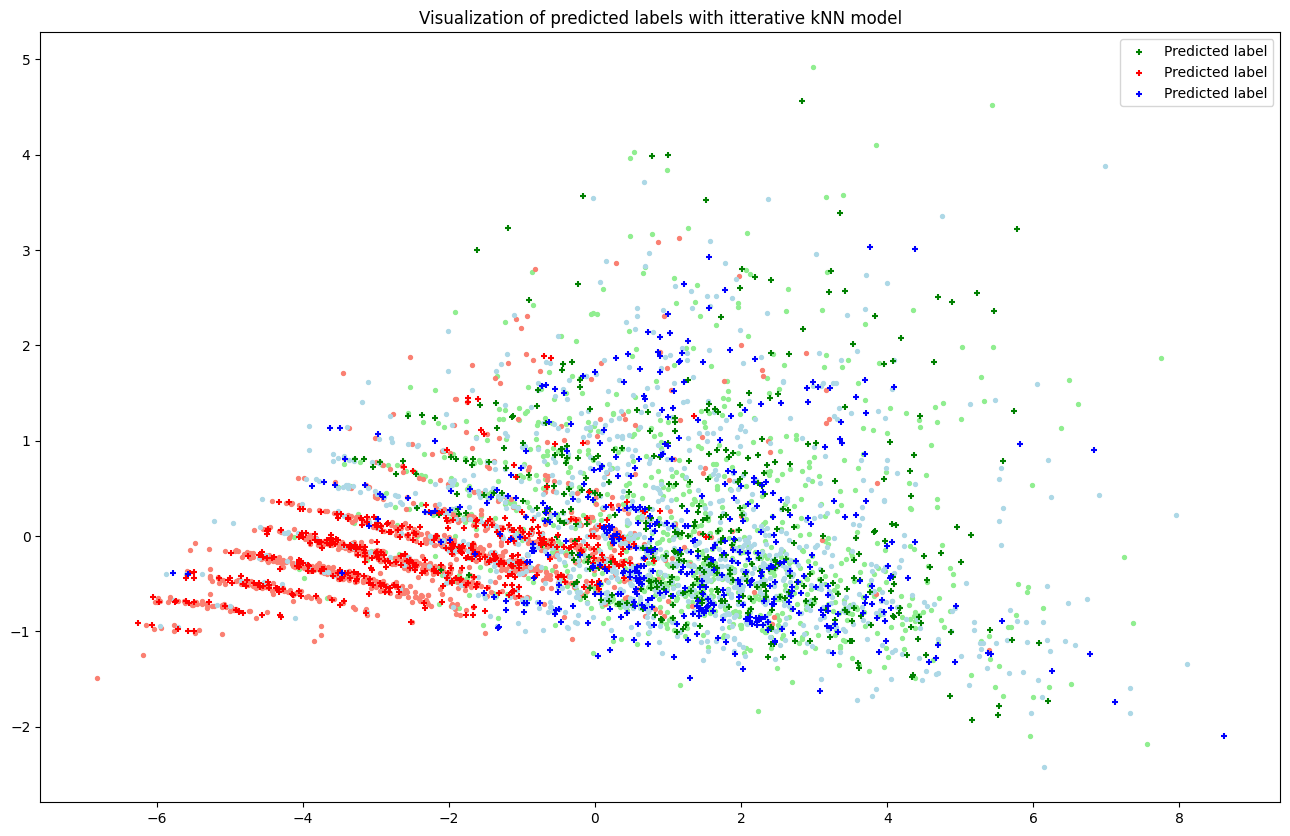

*** Vector model ***
Accuracy for vector kNN model: 52.71132376395534%
It took 6.563730716705322 seconds to make the prediction based on the 6 nearest neighbors.



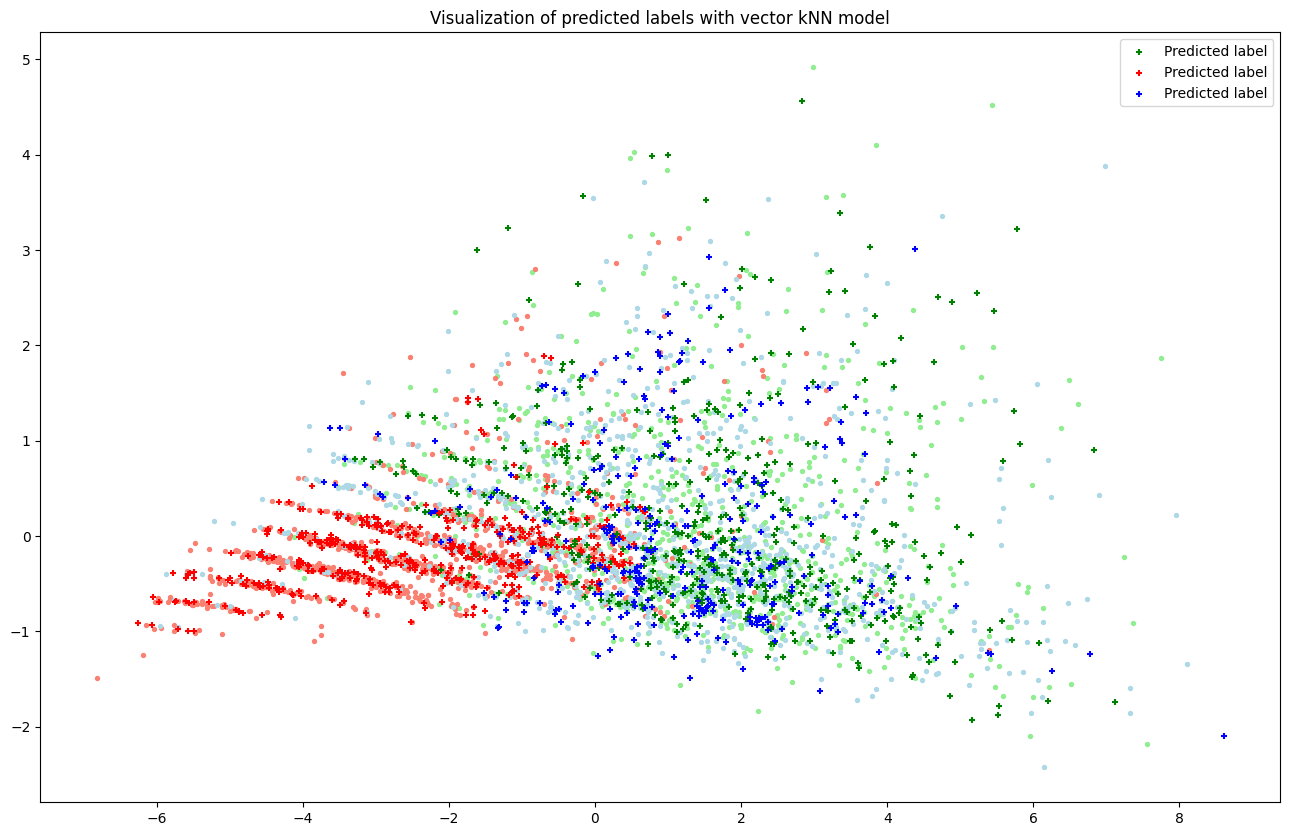

In [28]:
# Task 3, 

##############################################################################################################

k = 6       #I get the best accuracy value with this value of k for this dataset. 

##############################################################################################################

#kNN model from scikit-learn as reference
reference_model = KNeighborsClassifier(n_neighbors=k)
reference_model.fit(X_train, y_train)

t2 = time.time()
y_predicted = reference_model.predict(X_test)
sec = time.time() - t2

def accuracy(predicted_labels, true_labels):
    # Count correct predictions
    accuracy_count = sum(pred == true for pred, true in zip(predicted_labels, true_labels))
    # Calculate accuracy percentage
    accuracy_percentage = (accuracy_count / len(true_labels)) * 100
    return accuracy_percentage

print(f"*** For reference ***")
print(f"Accuracy for the scikit-learn kNN model: {accuracy(y_predicted, y_test)}%")
print(f"It took {sec} seconds to make the prediction based on the {k} nearest neighbors.")
print()

##############################################################################################################

#Itterative kNN model for lists
itterative = KNN_itterative(k)
itterative.fit(X_train_as_list, y_train_as_list)

t0 = time.time()
itterative_predictions = itterative.predict(X_test_as_list)
sec = time.time() - t0

print(f"*** Itterative model ***")
print(f"Accuracy for itterative kNN model: {itterative.test_accuracy(y_test_as_list)}%")
print(f"It took {sec} seconds to make the prediction based on the {k} nearest neighbors.")
print()
itterative.plot()

##############################################################################################################

#Vector kNN model for numpy arrays
vector = KNN_vector(k)
vector.fit(X_train, y_train)

t1 = time.time()
vector_predictions = vector.predict(X_test)
sec = time.time() - t1

print(f"*** Vector model ***")
print(f"Accuracy for vector kNN model: {itterative.test_accuracy(y_test)}%")
print(f"It took {sec} seconds to make the prediction based on the {k} nearest neighbors.")
print()
vector.plot()

##############################################################################################################